# PMF for Recommender Systems

This is an implementation for Probabilistic Matrix Factorisation. We have made use of a subset of the IMDB dataset for training purposes.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error

Let's now download our dataset. We will also unzip it for further use.

In [2]:
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

zsh:1: command not found: wget
unzip:  cannot find or open ml-latest-small.zip, ml-latest-small.zip.zip or ml-latest-small.zip.ZIP.


Let's take a look at part of the ratings file to get an idea of the columns available.

In [6]:
df = pd.read_csv('/Users/partht/Downloads/ml-latest-small/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


As part of the dataset, there is also another file that contains movie information, which includes the movie id, the title, the genre, among others. We can INNER JOIN the ratings and movies datasets to gain access to all data we will need for our analysis.

In [7]:
df_movies = pd.read_csv('/Users/partht/Downloads/ml-latest-small/movies.csv')
df_join = pd.merge(df_movies, df, how='inner', on='movieId')
df_join.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


Let's now prepare our sparse review matrix. For this purpose, we first need to find out how many users and movies we have in our dataset. Additionally, we will set S to 5 dimensions.

In [8]:
def get_ratings_matrix(df, train_size=0.75):
    user_to_row = {}
    movie_to_column = {}
    df_values = df.values
    n_dims = 10
    parameters = {}
    
    uniq_users = np.unique(df_values[:, 3])
    uniq_movies = np.unique(df_values[:, 0])

    for i, user_id in enumerate(uniq_users):
        user_to_row[user_id] = i

    for j, movie_id in enumerate(uniq_movies):
        movie_to_column[movie_id] = j
    
    n_users = len(uniq_users)
    n_movies = len(uniq_movies)
    
    R = np.zeros((n_users, n_movies))
    
    df_copy = df.copy()
    train_set = df_copy.sample(frac=train_size, random_state=0)
    test_set = df_copy.drop(train_set.index)
    
    for index, row in train_set.iterrows():
        i = user_to_row[row.userId]
        j = movie_to_column[row.movieId]
        R[i, j] = row.rating

    return R, train_set, test_set, n_dims, n_users, n_movies, user_to_row, movie_to_column

Let's now call this function and retrieve all necessary parameters.

In [9]:
R, train_set, test_set, n_dims, n_users, n_movies, user_to_row, movie_to_column = get_ratings_matrix(df_join, 0.8)
parameters = {}

We will now initialise our parameters. First the $V$ matrix can be initialised randomly using the following distribution:

\begin{equation}
\large
V \sim \mathcal N\left(0, \frac {1} {\lambda_V}\right)
\end{equation}

Let's remember that:

\begin{equation}
\large
U \in \mathbb R^{D\times N}, \qquad V \in \mathbb R^{D\times M}
\end{equation}

Where $N$ is __n_users__, $M$ is __n_movies__ and $D$ is __n_dims__.

In [24]:
# Initialize Parameters with Gaussian Priors
def initialize_parameters(lambda_U, lambda_V):
    """
    Initializes user (U) and item (V) matrices with Gaussian priors.
    
    U: Zero-mean prior with no variance scaling (zeros initialization).
    V: Gaussian distribution N(0, 1/lambda_V).
    
    Parameters:
    - lambda_U: Regularization parameter for user features.
    - lambda_V: Regularization parameter for item features.
    """
    U = np.zeros((n_dims, n_users), dtype=np.float64)  # Zero-mean Gaussian prior
    V = np.random.normal(0.0, 1.0 / lambda_V, (n_dims, n_movies))  # Gaussian prior for items
    
    parameters['U'] = U
    parameters['V'] = V
    parameters['lambda_U'] = lambda_U
    parameters['lambda_V'] = lambda_V

In [27]:
def gradient_descent_step(learning_rate):
    """
    Performs a single gradient descent step to update U and V matrices.
    Gradients are computed with respect to the log-posterior.
    
    """
    U = parameters['U']
    V = parameters['V']
    lambda_U = parameters['lambda_U']
    lambda_V = parameters['lambda_V']
    
    # Gradients for U and V
    U_grad = -np.dot(V, (R - np.dot(U.T, V)).T) + lambda_U * U
    V_grad = -np.dot(U, (R - np.dot(U.T, V))) + lambda_V * V
    
    # Update U and V
    U -= learning_rate * U_grad
    V -= learning_rate * V_grad
    
    parameters['U'] = U
    parameters['V'] = V

Now let's implement the Log-a posteriori:

\begin{equation}
\large
L=-\frac 1 2 \left(\sum_{i=1}^N\sum_{j=1}^M(R_{ij}-U_i^TV_j)_{(i,j) \in \Omega_{R_{ij}}}^2+\lambda_U\sum_{i=1}^N\|U_i\|_{Fro}^2+\lambda_V\sum_{j=1}^M\|V_j\|_{Fro}^2\right)
\end{equation}

In [28]:
def log_a_posteriori():
    """
    Computes the log-posterior for the PMF model
    
    Components:
    - Likelihood: Gaussian likelihood for observed ratings.
    - Priors: Regularization terms for U and V matrices.
    """
    lambda_U = parameters['lambda_U']
    lambda_V = parameters['lambda_V']
    U = parameters['U']
    V = parameters['V']
    
    # Likelihood component
    UV = np.dot(U.T, V)
    R_UV = (R[R > 0] - UV[R > 0])  # Difference for observed ratings
    
    # Priors (regularization terms)
    U_prior = lambda_U * np.sum(U**2)
    V_prior = lambda_V * np.sum(V**2)
    
    return -0.5 * (np.sum(R_UV**2) + U_prior + V_prior)

The __predict__ function allows us to predict the rating value given the __user_id__ and the __movie_id__ parameters. The value has been scaled within the range 0-5

In [29]:
def predict(user_id, movie_id):
    U = parameters['U']
    V = parameters['V']
    
    r_ij = U[:, user_to_row[user_id]].T.reshape(1, -1) @ V[:, movie_to_column[movie_id]].reshape(-1, 1)

    max_rating = parameters['max_rating']
    min_rating = parameters['min_rating']

    return 0 if max_rating == min_rating else ((r_ij[0][0] - min_rating) / (max_rating - min_rating)) * 5.0

The __evaluate__ function will calculate the __RMSE__ of the model given a dataset (train or test).

In [30]:
def evaluate(dataset):
    """
    Evaluates the model's performance using RMSE (Root Mean Squared Error).
    
    RMSE quantifies the average prediction error. Lower values indicate better accuracy.
    
    """
    ground_truths = []
    predictions = []
    
    for _, row in dataset.iterrows():
        ground_truths.append(row['rating'])
        predictions.append(predict(row['userId'], row['movieId']))
    
    return mean_squared_error(ground_truths, predictions, squared=False)

For the purposes of scaling, we need the maximum and minimum rating values.

In [31]:
def update_max_min_ratings():
    U = parameters['U']
    V = parameters['V']

    R = U.T @ V
    min_rating = np.min(R)
    max_rating = np.max(R)

    parameters['min_rating'] = min_rating
    parameters['max_rating'] = max_rating

The __train__ function implements the code necessary for training the model as well as recording the __RMSE__ values on the training and testing sets.

In [32]:
def train(n_epochs):
    initialize_parameters(0.3, 0.3)
    log_aps = []
    rmse_train = []
    rmse_test = []

    update_max_min_ratings()
    rmse_train.append(evaluate(train_set))
    rmse_test.append(evaluate(test_set))
    
    for k in range(n_epochs):
        update_parameters()
        log_ap = log_a_posteriori()
        log_aps.append(log_ap)

        if (k + 1) % 10 == 0:
            update_max_min_ratings()

            rmse_train.append(evaluate(train_set))
            rmse_test.append(evaluate(test_set))
            print('Log p a-posteriori at iteration', k + 1, ':', log_ap)

    update_max_min_ratings()

    return log_aps, rmse_train, rmse_test

Let's train our model!

In [33]:
log_ps, rmse_train, rmse_test = train(150)

Log p a-posteriori at iteration 10 : -24532.169457872486
Log p a-posteriori at iteration 20 : -17037.326646244324
Log p a-posteriori at iteration 30 : -14567.727164381355
Log p a-posteriori at iteration 40 : -13374.207748195755
Log p a-posteriori at iteration 50 : -12681.761898571687
Log p a-posteriori at iteration 60 : -12260.29645120691
Log p a-posteriori at iteration 70 : -11986.316293452395
Log p a-posteriori at iteration 80 : -11801.05874833944
Log p a-posteriori at iteration 90 : -11671.503864540278
Log p a-posteriori at iteration 100 : -11578.225746442185
Log p a-posteriori at iteration 110 : -11507.78623321844
Log p a-posteriori at iteration 120 : -11451.866460515581
Log p a-posteriori at iteration 130 : -11407.259164562773
Log p a-posteriori at iteration 140 : -11372.018898333352
Log p a-posteriori at iteration 150 : -11343.154199301967


Now let's take a look at some graphs

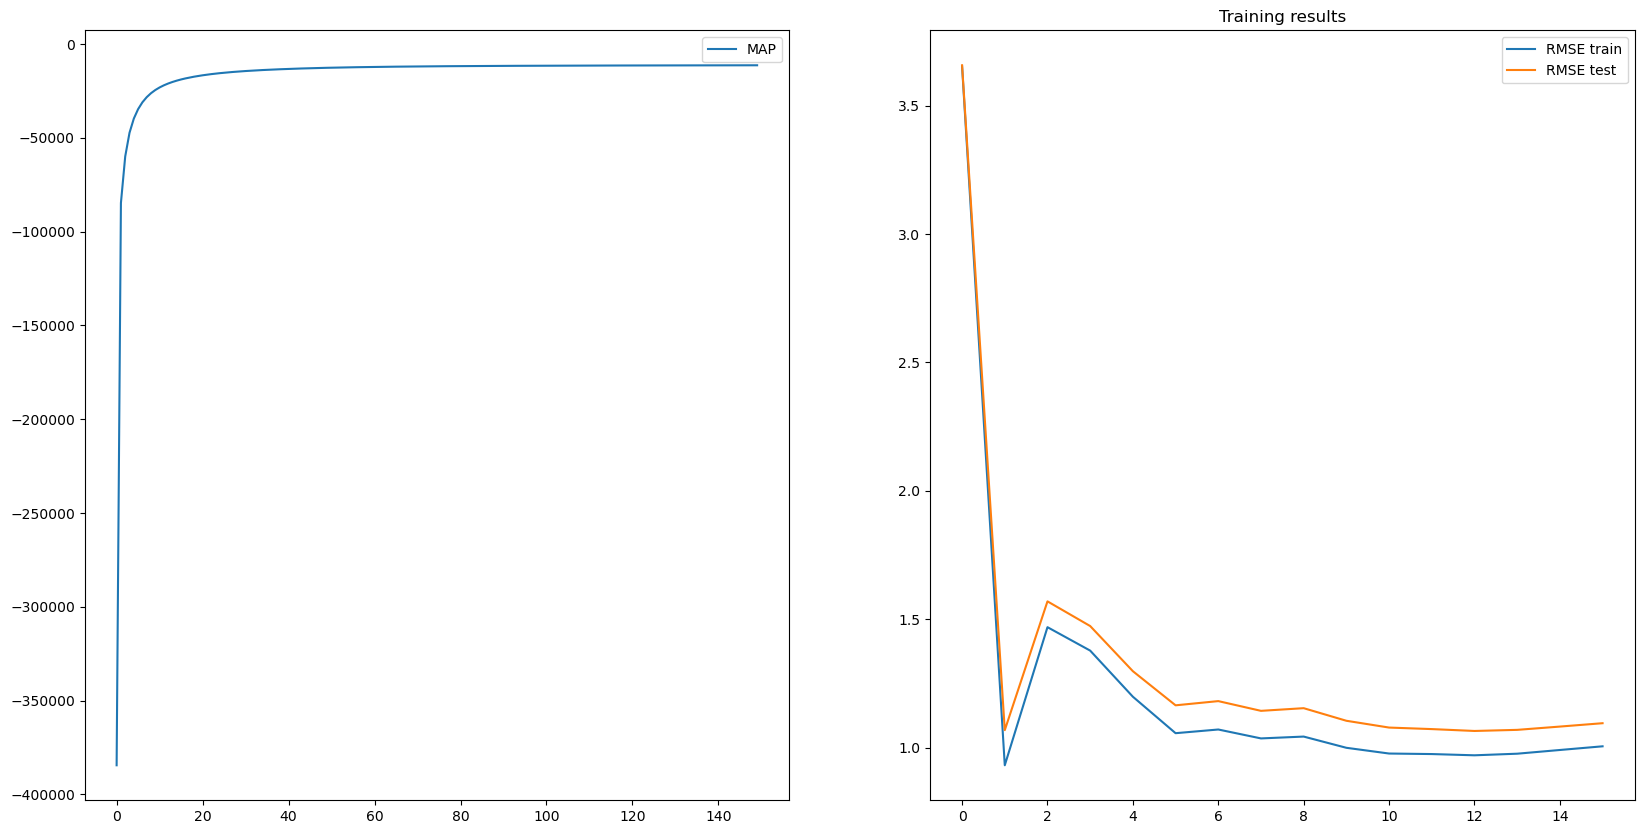

In [34]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
plt.title('Training results')
ax1.plot(np.arange(len(log_ps)), log_ps, label='MAP')
ax1.legend()

ax2.plot(np.arange(len(rmse_train)), rmse_train, label='RMSE train')
ax2.plot(np.arange(len(rmse_test)), rmse_test, label='RMSE test')
ax2.legend()

plt.show()

Let's now evaluate our model on both the training and testing sets.

In [35]:
print('RMSE of training set:', evaluate(train_set))
print('RMSE of testing set:', evaluate(test_set))

RMSE of training set: 1.0053875826550782
RMSE of testing set: 1.095324281943083


Now we will pick a user from the database and look at his/her preferences.

In [36]:
user_id = 45
df_join[df_join['userId'] == user_id].sort_values(by=['rating'], ascending=False).head(10)

,movieId,title,genres,userId,rating,timestamp
39202,2078,"Jungle Book, The (1967)",Animation|Children|Comedy|Musical,45,5.0,950726248
46609,2694,Big Daddy (1999),Comedy,45,5.0,951170525
46142,2657,"Rocky Horror Picture Show, The (1975)",Comedy|Horror|Musical|Sci-Fi,45,5.0,950741248
55533,3578,Gladiator (2000),Action|Adventure|Drama,45,5.0,1020803425
33101,1584,Contact (1997),Drama|Sci-Fi,45,5.0,950740871
56625,3717,Gone in 60 Seconds (2000),Action|Crime,45,5.0,1007994717
45369,2580,Go (1999),Comedy|Crime,45,5.0,951756858
56996,3753,"Patriot, The (2000)",Action|Drama|War,45,5.0,1007995101
57287,3793,X-Men (2000),Action|Adventure|Sci-Fi,45,5.0,1007995171
57418,3798,What Lies Beneath (2000),Drama|Horror|Mystery,45,5.0,1007995171


Let's look at the least preferred items.

In [37]:
df_join[df_join['userId'] == user_id].sort_values(by=['rating']).head(10)

,movieId,title,genres,userId,rating,timestamp
53154,3270,"Cutting Edge, The (1992)",Comedy|Drama|Romance,45,1.0,950718581
5111,173,Judge Dredd (1995),Action|Crime|Sci-Fi,45,1.0,950741335
44072,2470,Crocodile Dundee (1986),Adventure|Comedy,45,1.0,950740565
67895,5585,Ernest Scared Stupid (1991),Comedy,45,1.0,1034344038
62486,4502,Ernest Saves Christmas (1988),Children|Comedy,45,1.0,1034344018
60222,4104,Ernest Goes to Camp (1987),Comedy,45,1.0,1034344018
53115,3268,Stop! Or My Mom Will Shoot (1992),Action|Comedy,45,1.0,950740376
46306,2672,"Thirteenth Floor, The (1999)",Drama|Sci-Fi|Thriller,45,1.0,950741061
54299,3439,Teenage Mutant Ninja Turtles II: The Secret of...,Action|Children|Fantasy,45,1.0,1034344018
15160,569,Little Big League (1994),Comedy|Drama,45,2.0,950722240


Let's now look at the most likely preferences of the selected user.

In [39]:
predictions = np.zeros((n_movies, 1))
movie_to_column_items = np.array(list(movie_to_column.items()))
df_rows = []  # List to store rows for the DataFrame

# Generate predictions for all movies for the given user
for i, movie in enumerate(movie_to_column_items):
    predictions[i] = predict(user_id, movie[0])

# Sort predictions in descending order
indices = np.argsort(-predictions, axis=0)

# Get top 10 movies
for j in range(10):
    movie_id = int(movie_to_column_items[np.where(movie_to_column_items[:, 1] == indices[j])][0][0])
    df_row = {
        'UserID': user_id,
        'MovieID': movie_id,
        'Movie': df_movies[df_movies['movieId'] == movie_id].iloc[0]['title'],
        'Genres': df_movies[df_movies['movieId'] == movie_id].iloc[0]['genres'],
        'Prediction': predictions[indices[j]][0][0]
    }
    df_rows.append(df_row)

# Create a DataFrame from the collected rows
df_result = pd.DataFrame(df_rows)

df_result


,UserID,MovieID,Movie,Genres,Prediction
0,45,1378,Young Guns (1988),Action|Comedy|Western,3.600125
1,45,102903,Now You See Me (2013),Crime|Mystery|Thriller,3.594754
2,45,133419,Pitch Perfect 2 (2015),Comedy,3.568748
3,45,3441,Red Dawn (1984),Action|Drama|War,3.566968
4,45,89904,The Artist (2011),Comedy|Drama|Romance,3.546616
5,45,30707,Million Dollar Baby (2004),Drama,3.528642
6,45,106487,The Hunger Games: Catching Fire (2013),Action|Adventure|Sci-Fi|IMAX,3.528182
7,45,55721,Elite Squad (Tropa de Elite) (2007),Action|Crime|Drama|Thriller,3.512346
8,45,3969,Pay It Forward (2000),Drama,3.490879
9,45,67255,"Girl with the Dragon Tattoo, The (Män som hata...",Crime|Drama|Mystery|Thriller,3.487619


Now the predictions for least preferred items.

In [41]:
df_rows = []  # Initialize an empty list to store rows
indices = np.argsort(predictions, axis=0)  # Sort predictions in ascending order

for j in range(10):  # Loop through the top 10 predictions
    movie_id = int(movie_to_column_items[np.where(movie_to_column_items[:, 1] == indices[j])][0][0])
    df_row = {
        'UserID': user_id,
        'MovieID': movie_id,
        'Movie': df_movies[df_movies['movieId'] == movie_id].iloc[0]['title'],
        'Genres': df_movies[df_movies['movieId'] == movie_id].iloc[0]['genres'],
        'Prediction': predictions[indices[j]][0][0]
    }
    df_rows.append(df_row)  # Append the row as a dictionary to the list

# Convert the list of rows into a DataFrame
df_result = pd.DataFrame(df_rows)

df_result

,UserID,MovieID,Movie,Genres,Prediction
0,45,2367,King Kong (1976),Adventure|Fantasy|Romance|Sci-Fi|Thriller,2.326124
1,45,155,Beyond Rangoon (1995),Adventure|Drama|War,2.391058
2,45,132046,Tomorrowland (2015),Action|Adventure|Children|Mystery|Sci-Fi,2.409350
3,45,1759,"Four Days in September (O Que É Isso, Companhe...",Drama,2.412734
4,45,495,In the Realm of the Senses (Ai no corrida) (1976),Drama,2.412734
5,45,3637,Vagabond (Sans toit ni loi) (1985),Drama,2.412734
6,45,1437,"Cement Garden, The (1993)",Drama,2.412734
7,45,3531,All the Vermeers in New York (1990),Comedy|Drama|Romance,2.412734
8,45,2512,"Ballad of Narayama, The (Narayama bushiko) (1983)",Drama,2.412734
9,45,1310,Hype! (1996),Documentary,2.412734
